# SEGY 2016 Facies Competition


In 2016 Matt @ Agile & Brendon @ Enthought setup a Machine Learning Contest with the SEG. 

The objective was to predict facies logs from a small set of well log data. The image below (source: www.agilescientific.com) shows the wirelines and facies targets for one well

![](agile_blog_seg_facies_image.png)

Two wells were held out as blind and used to create the final scores.

![](leaderboard.png)

In this notebook, we've taken the winning submission from `LA_Team` Lukas Mosser & Alfredo de la Fuente.

This Was Gradient Boosted Trees selected and tuned by TPOT.

here we are going to tune that model with Raytune instead


# Dependencies

In [1]:
%load_ext autoreload
%autoreload 2

from dependencies import *

Loading dependencies we have already seen...
Importing ray...
Done...


We have already applied the preprocessing steps from the contest entry notebook and saved these to `h5py` so we can load these here

In [5]:
import h5py


# define a loading function
def setup(filepath):
    with h5py.File(filepath, 'r') as f:
        X_train = f["train_x"][:]
        y_train = f["train_y"][:]
        group_train = f["train_groups"][:]
        train_wells = f["train_groups"].attrs["well_names"]        
        
        X_test = f["test_x"][:]
        y_test = None
#         y_test = f["test_y"]
        group_test = f["test_groups"][:]
        test_wells = f["test_groups"].attrs["well_names"]

    return X_train, y_train, group_train, X_test, y_test, group_test, (train_wells, test_wells)

The tuned model parameters
```
XGBClassifier(learning_rate=0.12,
              max_depth=3,
              min_child_weight=10,
              n_estimators=150,
              seed=seed,
              colsample_bytree=0.9)
```

Let's check the data is on the expected path

In [6]:
from os import path
filepath = path.abspath('../datasets/seg_2016_facies/la_team_5_data.h5py')
print(filepath)

/home/steve/dev/transform-2020-ray/datasets/seg_2016_facies/la_team_5_data.h5py


## Tuning function

Again we define an end to end tuning function

In [7]:
from sklearn.model_selection import LeavePGroupsOut
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from scipy.signal import medfilt
from filelock import FileLock

def e2e_train_and_test(config, **kwargs):
    
    # load the data
    X, y, groups, X_test, y_test, group_test, well_names = setup(kwargs['filepath'])
    
    #
    # chose your CV strategy. groups == wells
    #
    splitter = LeavePGroupsOut(1)
    
    #
    # run k fold training and validation
    #
    f1_scores = [] # keep hold of all individual scores
    for train_ind, val_ind in splitter.split(X, y, groups=groups):
        pipeline = make_pipeline(RobustScaler(),
                                  XGBClassifier())

        pipeline.set_params(**config)
        pipeline.fit(X[train_ind], y[train_ind])
        
        y_pred = pipeline.predict(X[val_ind])
        
        f1_scores.append(f1_score(y_pred, y[val_ind], average='micro'))
    
        # Clean isolated facies for each well
        y_pred = medfilt(y_pred, kernel_size=5)
    
    #
    # use tune's reporter
    #
    tune.track.log(
                mean_f1_score=np.array(f1_scores).mean(),
                std_f1_score=np.array(f1_scores).std(),
                # and we can actually add any metrics we like
                done=True)

The following config is locked to the winning parameters

In [6]:
tuning_config = {
    'xgbclassifier__learning_rate': 0.12,
    'xgbclassifier__max_depth': 3,
    'xbgclassifier__min_child_weight' :10,
    'xbgclassifier__n_estimators': 150,
    'xgbclassifier__seed':1773,
    'xgbclassifier__colsample_bytree':0.9
}

Let's update that to use distributions

In [10]:
ray_tuning_config = {
    'xgbclassifier__learning_rate': tune.loguniform(0.001, 0.5),
    'xgbclassifier__max_depth': tune.randint(1, 10),
    'xgbclassifier__min_child_weight': tune.loguniform(0.1,100),
    'xgbclassifier__n_estimators': tune.randint(5,200),
    'xgbclassifier__colsample_bytree': tune.choice([0.4, 0.6, 0.8, 1.0]),
    'xgbclassifier__lambda': tune.choice([0,1]),
    'xgbclassifier__seed': 42
}

In [19]:
ray.shutdown()
ray.init(num_cpus=6, num_gpus=0, include_webui=True)

2020-06-11 12:49:01,236	INFO resource_spec.py:204 -- Starting Ray with 34.62 GiB memory available for workers and up to 17.32 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-11 12:49:01,498	INFO services.py:1168 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '192.168.1.39',
 'raylet_ip_address': '192.168.1.39',
 'redis_address': '192.168.1.39:24248',
 'object_store_address': '/tmp/ray/session_2020-06-11_12-49-01_235260_58108/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-06-11_12-49-01_235260_58108/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-06-11_12-49-01_235260_58108'}

In [11]:
filepath = path.abspath('../datasets/seg_2016_facies/la_team_5_data.h5py')

# wrap our end to end function to inject our filepath
def e2e_seg(config):
    return e2e_train_and_test(config, filepath=filepath)

analysis = tune.run(
                e2e_seg,
                config=ray_tuning_config,
    
                num_samples=10, # Specify the number of samples to make from (non grid) distributions
    
                resources_per_trial=dict(cpu=1, gpu=0),
                
                local_dir="~/ray_results/seg_facies")

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators
e2e_seg_00000,RUNNING,,0.8,0,0.0133942,6,49.0161,103
e2e_seg_00001,PENDING,,0.6,0,0.316682,9,0.943907,124
e2e_seg_00002,PENDING,,0.6,0,0.00372102,7,0.409123,97
e2e_seg_00003,PENDING,,0.6,1,0.00773461,2,19.8539,158
e2e_seg_00004,PENDING,,0.8,0,0.00691101,9,0.159167,52
e2e_seg_00005,PENDING,,1,0,0.0427273,1,1.25305,176
e2e_seg_00006,PENDING,,0.8,0,0.156161,6,10.3762,156
e2e_seg_00007,PENDING,,0.4,1,0.0210836,8,0.251113,70
e2e_seg_00008,PENDING,,0.6,0,0.00885029,9,31.5247,60
e2e_seg_00009,PENDING,,1,1,0.19242,8,13.3125,95


(pid=59337) 2020-06-11 12:45:46,464	INFO trainable.py:217 -- Getting current IP.
(pid=59335) 2020-06-11 12:45:46,518	INFO trainable.py:217 -- Getting current IP.
(pid=59340) 2020-06-11 12:45:46,520	INFO trainable.py:217 -- Getting current IP.
(pid=59339) 2020-06-11 12:45:46,640	INFO trainable.py:217 -- Getting current IP.
(pid=59338) 2020-06-11 12:45:46,614	INFO trainable.py:217 -- Getting current IP.
(pid=59336) 2020-06-11 12:45:46,655	INFO trainable.py:217 -- Getting current IP.


2020-06-11 12:46:08,381	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 0}


Result for e2e_seg_00005:
  date: 2020-06-11_12-46-08
  done: true
  experiment_id: 8a1e383351ec420da42b1396e89fbada
  experiment_tag: 5_xgbclassifier__colsample_bytree=1.0,xgbclassifier__lambda=0,xgbclassifier__learning_rate=0.042727,xgbclassifier__max_depth=1,xgbclassifier__min_child_weight=1.2531,xgbclassifier__n_estimators=176
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.506615273192691
  node_ip: 192.168.1.39
  pid: 59338
  std_f1_score: 0.11553826859358274
  time_since_restore: 21.75893211364746
  time_this_iter_s: 21.75893211364746
  time_total_s: 21.75893211364746
  timestamp: 1591875968
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00005'
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_00000,RUNNING,,0.8,0,0.0133942,6,49.0161,103,,
e2e_seg_00001,RUNNING,,0.6,0,0.316682,9,0.943907,124,,
e2e_seg_00002,RUNNING,,0.6,0,0.00372102,7,0.409123,97,,
e2e_seg_00003,RUNNING,,0.6,1,0.00773461,2,19.8539,158,,
e2e_seg_00004,RUNNING,,0.8,0,0.00691101,9,0.159167,52,,
e2e_seg_00005,TERMINATED,,1,0,0.0427273,1,1.25305,176,0,21.7589
e2e_seg_00006,PENDING,,0.8,0,0.156161,6,10.3762,156,,
e2e_seg_00007,PENDING,,0.4,1,0.0210836,8,0.251113,70,,
e2e_seg_00008,PENDING,,0.6,0,0.00885029,9,31.5247,60,,
e2e_seg_00009,PENDING,,1,1,0.19242,8,13.3125,95,,


(pid=59578) 2020-06-11 12:46:09,353	INFO trainable.py:217 -- Getting current IP.


2020-06-11 12:46:09,659	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 1}


Result for e2e_seg_00003:
  date: 2020-06-11_12-46-09
  done: true
  experiment_id: 8ae2e2d024b74e27b260e2a21ff4b545
  experiment_tag: 3_xgbclassifier__colsample_bytree=0.6,xgbclassifier__lambda=1,xgbclassifier__learning_rate=0.0077346,xgbclassifier__max_depth=2,xgbclassifier__min_child_weight=19.854,xgbclassifier__n_estimators=158
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5332182388635156
  node_ip: 192.168.1.39
  pid: 59337
  std_f1_score: 0.074432471733868
  time_since_restore: 23.18818974494934
  time_this_iter_s: 23.18818974494934
  time_total_s: 23.18818974494934
  timestamp: 1591875969
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00003'
  
(pid=59592) 2020-06-11 12:46:10,636	INFO trainable.py:217 -- Getting current IP.


2020-06-11 12:46:30,310	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 0}


Result for e2e_seg_00000:
  date: 2020-06-11_12-46-30
  done: true
  experiment_id: f0a2fe7924c74189a5158bbd619ea93c
  experiment_tag: 0_xgbclassifier__colsample_bytree=0.8,xgbclassifier__lambda=0,xgbclassifier__learning_rate=0.013394,xgbclassifier__max_depth=6,xgbclassifier__min_child_weight=49.016,xgbclassifier__n_estimators=103
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5222612565986864
  node_ip: 192.168.1.39
  pid: 59339
  std_f1_score: 0.10642663312000121
  time_since_restore: 43.662237882614136
  time_this_iter_s: 43.662237882614136
  time_total_s: 43.662237882614136
  timestamp: 1591875990
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00000'
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_00000,TERMINATED,,0.8,0,0.0133942,6,49.0161,103,0,43.6622
e2e_seg_00001,RUNNING,,0.6,0,0.316682,9,0.943907,124,,
e2e_seg_00002,RUNNING,,0.6,0,0.00372102,7,0.409123,97,,
e2e_seg_00003,TERMINATED,,0.6,1,0.00773461,2,19.8539,158,0,23.1882
e2e_seg_00004,RUNNING,,0.8,0,0.00691101,9,0.159167,52,,
e2e_seg_00005,TERMINATED,,1,0,0.0427273,1,1.25305,176,0,21.7589
e2e_seg_00006,RUNNING,,0.8,0,0.156161,6,10.3762,156,,
e2e_seg_00007,RUNNING,,0.4,1,0.0210836,8,0.251113,70,,
e2e_seg_00008,PENDING,,0.6,0,0.00885029,9,31.5247,60,,
e2e_seg_00009,PENDING,,1,1,0.19242,8,13.3125,95,,


(pid=59623) 2020-06-11 12:46:31,266	INFO trainable.py:217 -- Getting current IP.


2020-06-11 12:46:34,698	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 0}


Result for e2e_seg_00004:
  date: 2020-06-11_12-46-34
  done: true
  experiment_id: 44dfe17ee87a4ba7bf8f5e97eaa82804
  experiment_tag: 4_xgbclassifier__colsample_bytree=0.8,xgbclassifier__lambda=0,xgbclassifier__learning_rate=0.006911,xgbclassifier__max_depth=9,xgbclassifier__min_child_weight=0.15917,xgbclassifier__n_estimators=52
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5614708010738226
  node_ip: 192.168.1.39
  pid: 59335
  std_f1_score: 0.10356880677307902
  time_since_restore: 48.17151212692261
  time_this_iter_s: 48.17151212692261
  time_total_s: 48.17151212692261
  timestamp: 1591875994
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00004'
  


2020-06-11 12:46:35,258	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 0}


Result for e2e_seg_00001:
  date: 2020-06-11_12-46-35
  done: true
  experiment_id: 1590a70c985f4456815152ddf83cbb1e
  experiment_tag: 1_xgbclassifier__colsample_bytree=0.6,xgbclassifier__lambda=0,xgbclassifier__learning_rate=0.31668,xgbclassifier__max_depth=9,xgbclassifier__min_child_weight=0.94391,xgbclassifier__n_estimators=124
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5797599446262108
  node_ip: 192.168.1.39
  pid: 59340
  std_f1_score: 0.09851287122332977
  time_since_restore: 48.730149269104004
  time_this_iter_s: 48.730149269104004
  time_total_s: 48.730149269104004
  timestamp: 1591875995
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00001'
  
(pid=59637) 2020-06-11 12:46:35,656	INFO trainable.py:217 -- Getting current IP.


2020-06-11 12:46:40,335	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 0}


Result for e2e_seg_00002:
  date: 2020-06-11_12-46-40
  done: true
  experiment_id: 9486fd3ffc4449bfa51f28526cf82953
  experiment_tag: 2_xgbclassifier__colsample_bytree=0.6,xgbclassifier__lambda=0,xgbclassifier__learning_rate=0.003721,xgbclassifier__max_depth=7,xgbclassifier__min_child_weight=0.40912,xgbclassifier__n_estimators=97
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5778618929096856
  node_ip: 192.168.1.39
  pid: 59336
  std_f1_score: 0.09730207614028051
  time_since_restore: 53.67314577102661
  time_this_iter_s: 53.67314577102661
  time_total_s: 53.67314577102661
  timestamp: 1591876000
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00002'
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_00000,TERMINATED,,0.8,0,0.0133942,6,49.0161,103,0,43.6622
e2e_seg_00001,TERMINATED,,0.6,0,0.316682,9,0.943907,124,0,48.7301
e2e_seg_00002,TERMINATED,,0.6,0,0.00372102,7,0.409123,97,0,53.6731
e2e_seg_00003,TERMINATED,,0.6,1,0.00773461,2,19.8539,158,0,23.1882
e2e_seg_00004,TERMINATED,,0.8,0,0.00691101,9,0.159167,52,0,48.1715
e2e_seg_00005,TERMINATED,,1,0,0.0427273,1,1.25305,176,0,21.7589
e2e_seg_00006,RUNNING,,0.8,0,0.156161,6,10.3762,156,,
e2e_seg_00007,RUNNING,,0.4,1,0.0210836,8,0.251113,70,,
e2e_seg_00008,RUNNING,,0.6,0,0.00885029,9,31.5247,60,,
e2e_seg_00009,RUNNING,,1,1,0.19242,8,13.3125,95,,


2020-06-11 12:46:40,611	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 1}


Result for e2e_seg_00007:
  date: 2020-06-11_12-46-40
  done: true
  experiment_id: 52ef724021204641a66a3d36107ebef9
  experiment_tag: 7_xgbclassifier__colsample_bytree=0.4,xgbclassifier__lambda=1,xgbclassifier__learning_rate=0.021084,xgbclassifier__max_depth=8,xgbclassifier__min_child_weight=0.25111,xgbclassifier__n_estimators=70
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5754231586868486
  node_ip: 192.168.1.39
  pid: 59592
  std_f1_score: 0.09908024715358979
  time_since_restore: 29.940154552459717
  time_this_iter_s: 29.940154552459717
  time_total_s: 29.940154552459717
  timestamp: 1591876000
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00007'
  


2020-06-11 12:46:57,921	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 0}


Result for e2e_seg_00008:
  date: 2020-06-11_12-46-57
  done: true
  experiment_id: 474be97f88c6451a87da23bb03f01ddf
  experiment_tag: 8_xgbclassifier__colsample_bytree=0.6,xgbclassifier__lambda=0,xgbclassifier__learning_rate=0.0088503,xgbclassifier__max_depth=9,xgbclassifier__min_child_weight=31.525,xgbclassifier__n_estimators=60
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5285489571888021
  node_ip: 192.168.1.39
  pid: 59623
  std_f1_score: 0.0822715127550726
  time_since_restore: 26.62748622894287
  time_this_iter_s: 26.62748622894287
  time_total_s: 26.62748622894287
  timestamp: 1591876017
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 00008
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_00000,TERMINATED,,0.8,0,0.0133942,6,49.0161,103,0,43.6622
e2e_seg_00001,TERMINATED,,0.6,0,0.316682,9,0.943907,124,0,48.7301
e2e_seg_00002,TERMINATED,,0.6,0,0.00372102,7,0.409123,97,0,53.6731
e2e_seg_00003,TERMINATED,,0.6,1,0.00773461,2,19.8539,158,0,23.1882
e2e_seg_00004,TERMINATED,,0.8,0,0.00691101,9,0.159167,52,0,48.1715
e2e_seg_00005,TERMINATED,,1,0,0.0427273,1,1.25305,176,0,21.7589
e2e_seg_00006,RUNNING,,0.8,0,0.156161,6,10.3762,156,,
e2e_seg_00007,TERMINATED,,0.4,1,0.0210836,8,0.251113,70,0,29.9402
e2e_seg_00008,TERMINATED,,0.6,0,0.00885029,9,31.5247,60,0,26.6275
e2e_seg_00009,RUNNING,,1,1,0.19242,8,13.3125,95,,


2020-06-11 12:47:17,549	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 0}


Result for e2e_seg_00006:
  date: 2020-06-11_12-47-17
  done: true
  experiment_id: f16d3ef915814c37994cfd3218afd209
  experiment_tag: 6_xgbclassifier__colsample_bytree=0.8,xgbclassifier__lambda=0,xgbclassifier__learning_rate=0.15616,xgbclassifier__max_depth=6,xgbclassifier__min_child_weight=10.376,xgbclassifier__n_estimators=156
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5765884943737118
  node_ip: 192.168.1.39
  pid: 59578
  std_f1_score: 0.09334620978966841
  time_since_restore: 68.17421627044678
  time_this_iter_s: 68.17421627044678
  time_total_s: 68.17421627044678
  timestamp: 1591876037
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: '00006'
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_00000,TERMINATED,,0.8,0,0.0133942,6,49.0161,103,0,43.6622
e2e_seg_00001,TERMINATED,,0.6,0,0.316682,9,0.943907,124,0,48.7301
e2e_seg_00002,TERMINATED,,0.6,0,0.00372102,7,0.409123,97,0,53.6731
e2e_seg_00003,TERMINATED,,0.6,1,0.00773461,2,19.8539,158,0,23.1882
e2e_seg_00004,TERMINATED,,0.8,0,0.00691101,9,0.159167,52,0,48.1715
e2e_seg_00005,TERMINATED,,1,0,0.0427273,1,1.25305,176,0,21.7589
e2e_seg_00006,TERMINATED,,0.8,0,0.156161,6,10.3762,156,0,68.1742
e2e_seg_00007,TERMINATED,,0.4,1,0.0210836,8,0.251113,70,0,29.9402
e2e_seg_00008,TERMINATED,,0.6,0,0.00885029,9,31.5247,60,0,26.6275
e2e_seg_00009,RUNNING,,1,1,0.19242,8,13.3125,95,,


2020-06-11 12:47:31,678	INFO logger.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'xgbclassifier__lambda': 1}


Result for e2e_seg_00009:
  date: 2020-06-11_12-47-31
  done: true
  experiment_id: 1fb32bebca274b8e9fe5334684d3947d
  experiment_tag: 9_xgbclassifier__colsample_bytree=1.0,xgbclassifier__lambda=1,xgbclassifier__learning_rate=0.19242,xgbclassifier__max_depth=8,xgbclassifier__min_child_weight=13.313,xgbclassifier__n_estimators=95
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_f1_score: 0.5697257887826627
  node_ip: 192.168.1.39
  pid: 59637
  std_f1_score: 0.08432330260295981
  time_since_restore: 55.98304605484009
  time_this_iter_s: 55.98304605484009
  time_total_s: 55.98304605484009
  timestamp: 1591876051
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 00009
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_00000,TERMINATED,,0.8,0,0.0133942,6,49.0161,103,0,43.6622
e2e_seg_00001,TERMINATED,,0.6,0,0.316682,9,0.943907,124,0,48.7301
e2e_seg_00002,TERMINATED,,0.6,0,0.00372102,7,0.409123,97,0,53.6731
e2e_seg_00003,TERMINATED,,0.6,1,0.00773461,2,19.8539,158,0,23.1882
e2e_seg_00004,TERMINATED,,0.8,0,0.00691101,9,0.159167,52,0,48.1715
e2e_seg_00005,TERMINATED,,1,0,0.0427273,1,1.25305,176,0,21.7589
e2e_seg_00006,TERMINATED,,0.8,0,0.156161,6,10.3762,156,0,68.1742
e2e_seg_00007,TERMINATED,,0.4,1,0.0210836,8,0.251113,70,0,29.9402
e2e_seg_00008,TERMINATED,,0.6,0,0.00885029,9,31.5247,60,0,26.6275
e2e_seg_00009,TERMINATED,,1,1,0.19242,8,13.3125,95,0,55.983


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_00000,TERMINATED,,0.8,0,0.0133942,6,49.0161,103,0,43.6622
e2e_seg_00001,TERMINATED,,0.6,0,0.316682,9,0.943907,124,0,48.7301
e2e_seg_00002,TERMINATED,,0.6,0,0.00372102,7,0.409123,97,0,53.6731
e2e_seg_00003,TERMINATED,,0.6,1,0.00773461,2,19.8539,158,0,23.1882
e2e_seg_00004,TERMINATED,,0.8,0,0.00691101,9,0.159167,52,0,48.1715
e2e_seg_00005,TERMINATED,,1,0,0.0427273,1,1.25305,176,0,21.7589
e2e_seg_00006,TERMINATED,,0.8,0,0.156161,6,10.3762,156,0,68.1742
e2e_seg_00007,TERMINATED,,0.4,1,0.0210836,8,0.251113,70,0,29.9402
e2e_seg_00008,TERMINATED,,0.6,0,0.00885029,9,31.5247,60,0,26.6275
e2e_seg_00009,TERMINATED,,1,1,0.19242,8,13.3125,95,0,55.983


In [12]:
from pprint import pprint
print("Best config: ")
pprint(analysis.get_best_config(metric="mean_f1_score"))

Best config: 
{'xgbclassifier__colsample_bytree': 0.6,
 'xgbclassifier__lambda': 0,
 'xgbclassifier__learning_rate': 0.31668235358328745,
 'xgbclassifier__max_depth': 9,
 'xgbclassifier__min_child_weight': 0.9439065152355695,
 'xgbclassifier__n_estimators': 124,
 'xgbclassifier__seed': 42}


In [13]:
df = analysis.dataframe()
top_n_df = df.nlargest(10, "mean_f1_score")

In [14]:
top_n_df.head()

,mean_f1_score,std_f1_score,done,trial_id,training_iteration,time_this_iter_s,timesteps_total,episodes_total,experiment_id,date,...,iterations_since_restore,experiment_tag,config/xgbclassifier__colsample_bytree,config/xgbclassifier__lambda,config/xgbclassifier__learning_rate,config/xgbclassifier__max_depth,config/xgbclassifier__min_child_weight,config/xgbclassifier__n_estimators,config/xgbclassifier__seed,logdir
1,0.579760,0.098513,True,1,0,48.730149,NaN,NaN,1590a70c985f4456815152ddf83cbb1e,2020-06-11_12-46-35,...,1,"1_xgbclassifier__colsample_bytree=0.6,xgbclass...",0.6,0,0.316682,9,0.943907,124,42,/home/steve/ray_results/seg_facies/e2e_seg/e2e...
2,0.577862,0.097302,True,2,0,53.673146,NaN,NaN,9486fd3ffc4449bfa51f28526cf82953,2020-06-11_12-46-40,...,1,"2_xgbclassifier__colsample_bytree=0.6,xgbclass...",0.6,0,0.003721,7,0.409123,97,42,/home/steve/ray_results/seg_facies/e2e_seg/e2e...
6,0.576588,0.093346,True,6,0,68.174216,NaN,NaN,f16d3ef915814c37994cfd3218afd209,2020-06-11_12-47-17,...,1,"6_xgbclassifier__colsample_bytree=0.8,xgbclass...",0.8,0,0.156161,6,10.376203,156,42,/home/steve/ray_results/seg_facies/e2e_seg/e2e...
7,0.575423,0.099080,True,7,0,29.940155,NaN,NaN,52ef724021204641a66a3d36107ebef9,2020-06-11_12-46-40,...,1,"7_xgbclassifier__colsample_bytree=0.4,xgbclass...",0.4,1,0.021084,8,0.251113,70,42,/home/steve/ray_results/seg_facies/e2e_seg/e2e...
9,0.569726,0.084323,True,9,0,55.983046,NaN,NaN,1fb32bebca274b8e9fe5334684d3947d,2020-06-11_12-47-31,...,1,"9_xgbclassifier__colsample_bytree=1.0,xgbclass...",1.0,1,0.192420,8,13.312523,95,42,/home/steve/ray_results/seg_facies/e2e_seg/e2e...


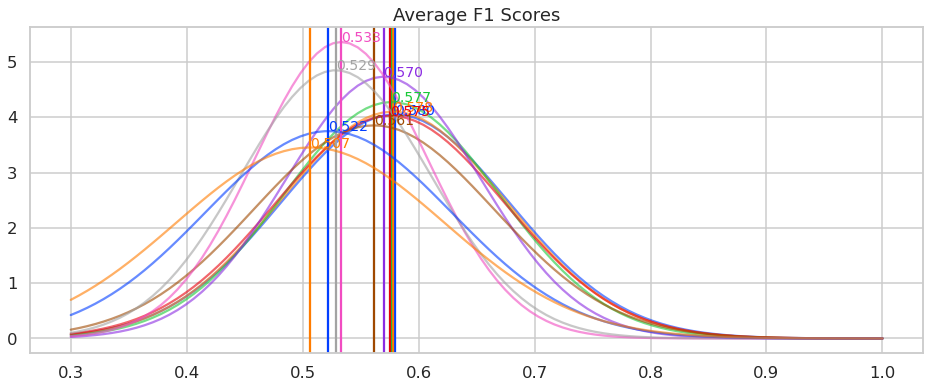

In [18]:
plot_some_tune_results(top_n_df, (0.3, 1.0))

In [16]:
%load_ext tensorboard
from tensorboard import notebook 
%tensorboard --logdir "~/ray_results/seg_facies"
notebook.display(height=1000)

Selecting TensorBoard with logdir ~/ray_results/seg_facies (started 0:00:01 ago; port 6007, pid 59692).


In [17]:
ray.shutdown()